# cloud removal using pretrained deep learning model and raster function

> * 🔬 Data Science
> * 🥠 Deep Learning and image translation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Generate cloud mask](#Generate-cloud-mask)
  * [Use cloud mask generation pretrained model](#Use-cloud-mask-generation-pretrained-model)
  * [Reclassify cloud types in cloud mask](#Reclassify-cloud-types-in-cloud-mask)
    * [Visualize the generated cloud mask](#Visualize-the-generated-cloud-mask)
* [Use stepwise local radiometric adjustment raster function](#Use-stepwise-local-radiometric-adjustment-raster-function)
* [Conclusion](#Conclusion)
* [References](#References)

# Introduction

The goal of this notebook is to detect and replace the cloud-contaminated region of the satellite images. Clouds often create obstructions in satellite imagery that can hinder results in processes like land cover classification and time series analysis. From a general perspective, this can be seen as an image denoising problem, where clouds are considered as noise in relation to the land surface in images. In this notebook, we will detect and replace cloud-contaminated regions of satellite imagery by combining a pretrained deep learning model, available in [Living Atlas](https://livingatlas.arcgis.com/en/home/), with an image processing technique available in [raster functions](https://github.com/Esri/raster-functions).

## Necessary imports

In [1]:
import matplotlib.pyplot as plt
import arcpy
from arcgis import GIS
from arcgis.learn import prepare_data, Pix2PixHD, Pix2Pix

## Connect to your GIS

In [2]:
gis = GIS('Home')

The rasters used for exporting the training dataset are provided below:

<Item title:"with_clouds_rasters.tif" type:Layer Package owner:api_data_owner>
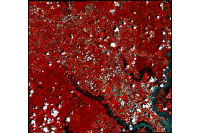

In [5]:
cloud_covered = gis.content.get('b89f64b064e84423b596a0252c044921')
cloud_covered

<Item title:"no_cloud.tif" type:Layer Package owner:api_data_owner>
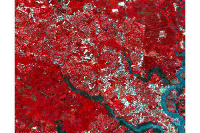

In [6]:
cloud_free = gis.content.get('5993a05593c945b0854ec87581750432')
cloud_free

## Cloud removal workflow

The cloud removal workflow employed in this notebook consists of three key steps:

1. **Generate cloud mask** - To initiate the cloud removal process, a cloud mask is generated using a pretrained model available in the [Living Atlas](https://geosaurus.maps.arcgis.com/home/item.html?id=1e1ec9602f4743108708ccdf362e3c48). This cloud mask serves as a guide for identifying and isolating cloud-contaminated pixels within the target raster.
2. **Reclassification of cloud types** - the generated cloud mask in step 1 has different cloud types. In this step, we assign a value of 1 to pixels associated with different cloud types, while assigning a value of 0 to all other non-cloud pixels.
3. **Use the stepwise local radiometric adjustment (SLRA) raster function** - The final step involves the application of the [Stepwise Local Radiometric Adjustment (SLRA)](https://github.com/Esri/raster-functions/blob/master/functions/StepwiseLocalRadiometricAdjustment.py) raster function. This function takes as input the original raster, a replacement raster, and the reclassified cloud mask from step 2. The function results in removal of clouds in input rasters.

## Generate cloud mask

The cloud mask generation pre-trained model, trained on sentinel-L2A imagery is used to generate cloud mask for input raster. The pre-trained model is used in `Classify Pixels Using Deep Learning` tool resulting in a segmented cloud mask raster. The cloud mask is used by `Stepwise local radiometric adjustment` (SLRA) raster function as guidance for removal of cloud-contaminated pixels in the target raster.

<Item title:"Cloud Mask Generation (Sentinel-2)" type:Deep Learning Package owner:esri_analytics>
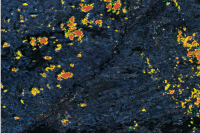

In [4]:
gis.content.get('1e1ec9602f4743108708ccdf362e3c48')

<div style="align: left; text-align:center; line-height: 5em">  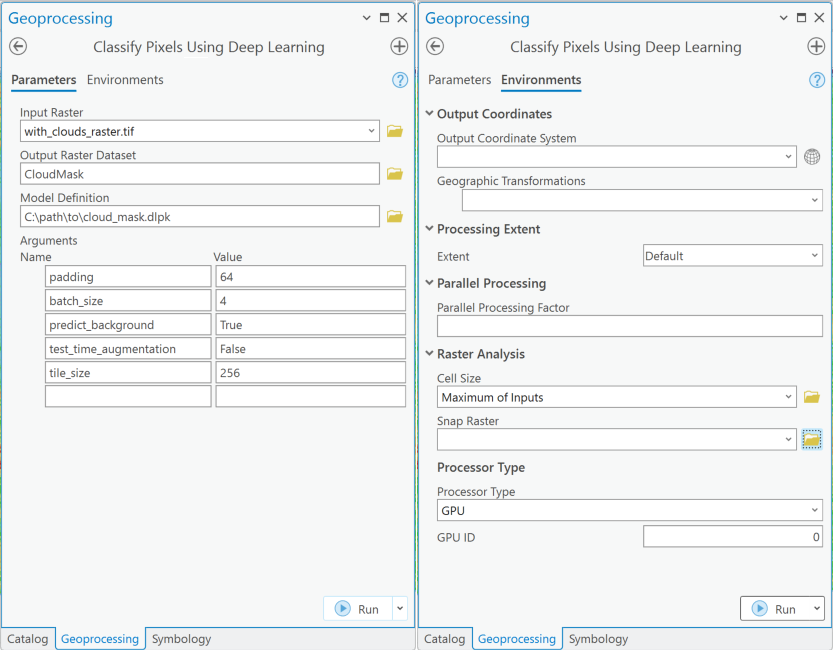

### Reclassify cloud types in the cloud mask

The pretrained cloud mask model will classify clouds into 3 classes. low, medium, and high density. As we want to remove all cloud contaminated regions, we will reclassify these 3 classes into one single class.

In [13]:
arcpy.env.workspace = r"location\to\arcgis_pro_project_geodatabase\cloud_removal.gdb"

cloud_mask = arcpy.Raster(r"cloud_mask.tif")
cloud_mask_arr = arcpy.RasterToNumPyArray(cloud_mask)

inRaster = "cloud_mask.tif"
field = "Value"
remapString = "1 1;2 1;3 1"
outRaster = "reclass_cloud_mask"

# Execute Reclassify
arcpy.ddd.Reclassify(cloud_mask, field, remapString, outRaster, "DATA")

### Visualize the generated cloud mask

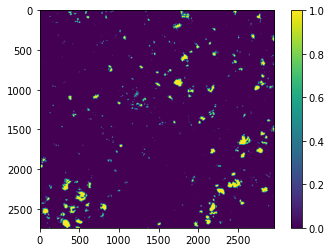

In [20]:
plt.imshow(cloud_mask_arr[50:-50,50:-50])
plt.colorbar()
plt.show()

## Use the stepwise local radiometric adjustment raster function

Next, we will use the Python raster function to blend areas using a Stepwise Local Radiometric Adjustment algorithm [Li .et al, 2019](https://www.mdpi.com/517118). Stepwise Local Radiometric Adjustment is used to fill contaminated areas and is performed on each mask region of the target image. Using the replacement raster, the tool will replace pixels that are covered with clouds. 

The raster functions can be downloaded as a python (.py) file named [raster functions](https://github.com/Esri/raster-functions) in the functions folder. The [StepwiseLocalRadiometricAdjustment.py](https://github.com/Esri/raster-functions/blob/master/functions/StepwiseLocalRadiometricAdjustment.py) file can be opened using `Open Python Raster function`. Once opened, save it using `Save As`. You can experiment with different values for the `Size of Window` and `Buffer Mask` parameters to achieve varying results based on your requirements and cloud coverage.

- `Input Raster`: cloud covered imagery
- `Input Replacement raster`: replacement raster
- `Input Mask`: generated cloud mask
- `Size of Window`: default set to 80, can be any multiple of 20
- `Buffer Mask`: any value between 0-15, accordiong to coverage of cloud mask

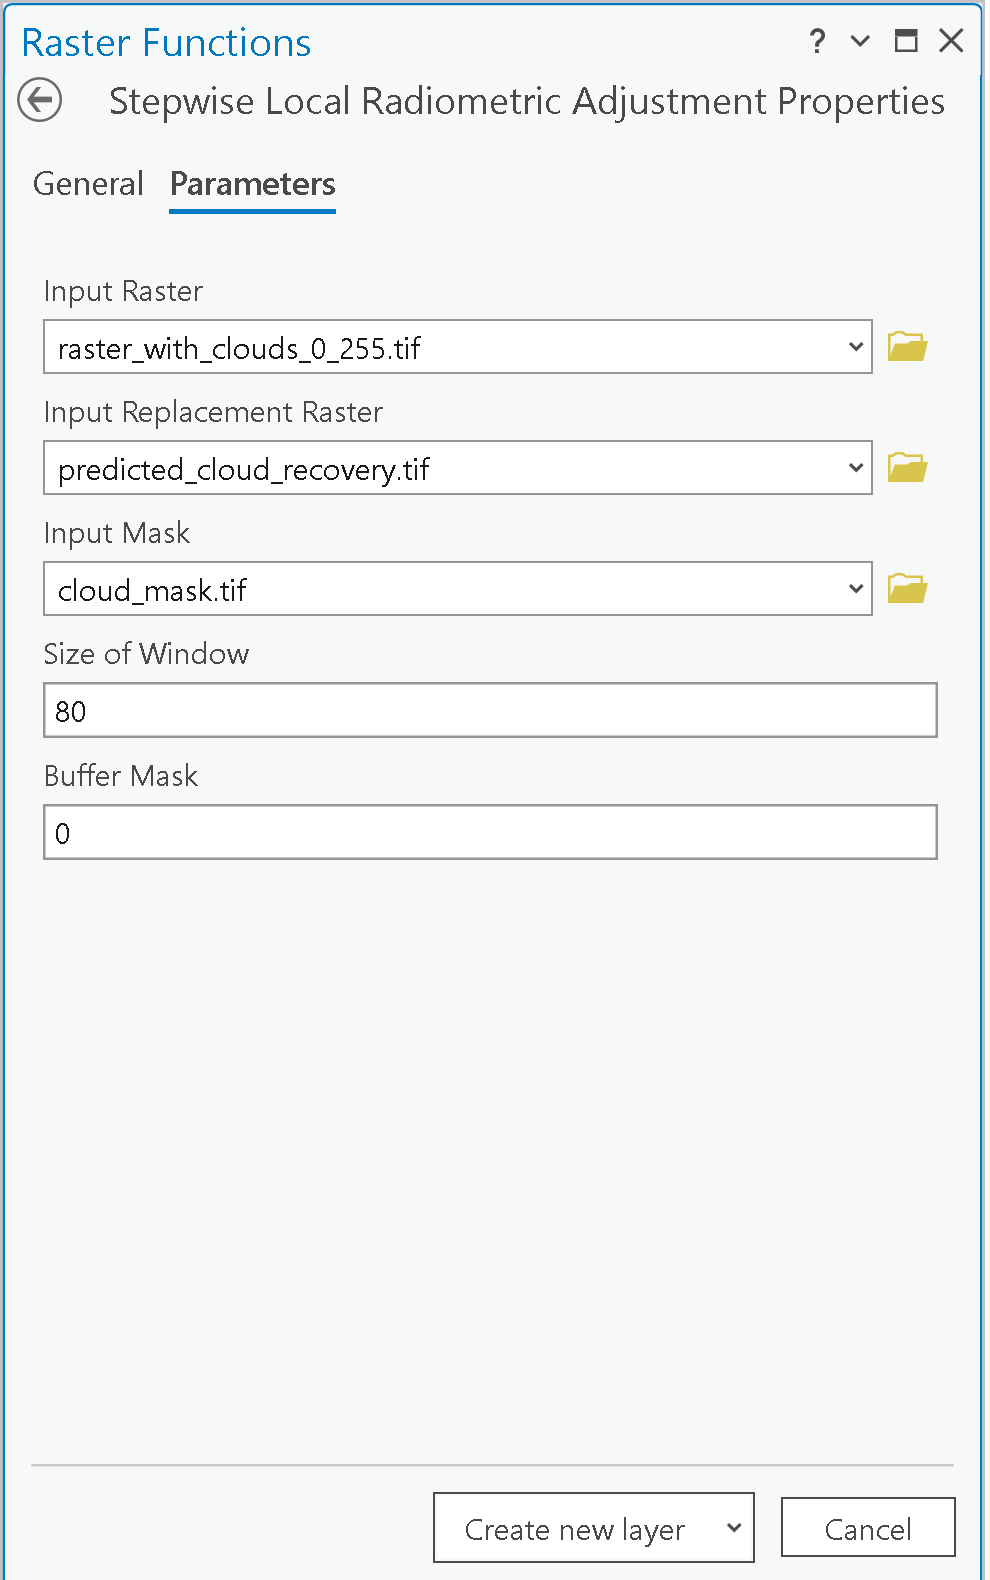

The saved raster function can then be exported as an rft(raster function template). rft is used in the `Generate Raster From Raster Function` tool to get the final results, as this tool is designed for raster processing using multiple threads to help speed up the processing.

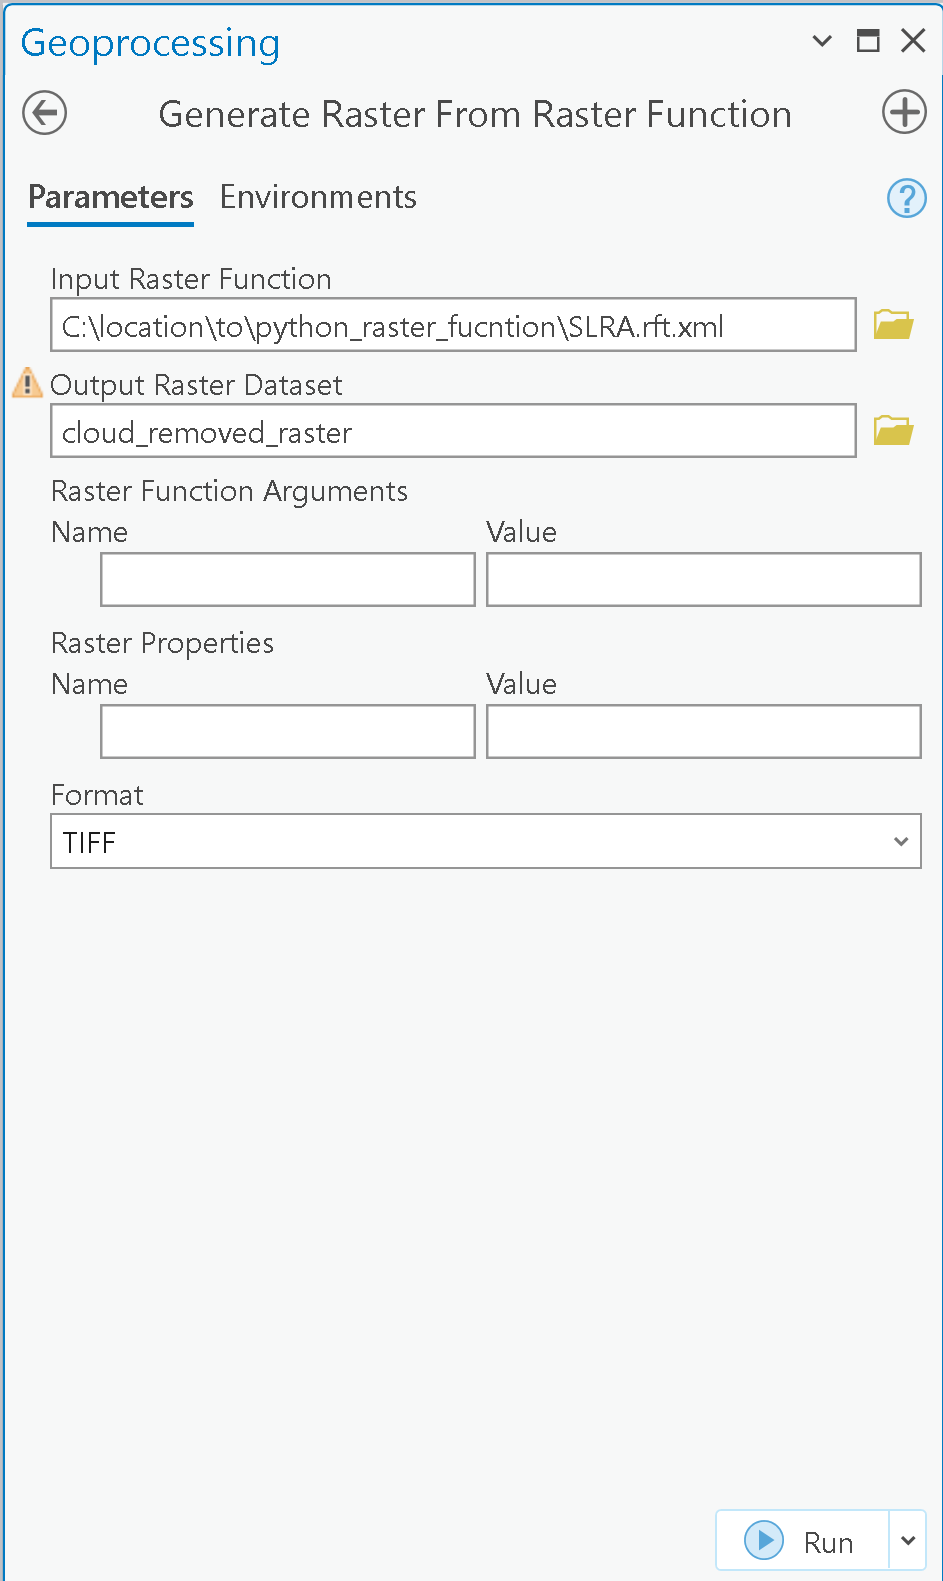

`arcpy.management.GenerateRasterFromRasterFunction(r"path\to\the\rft_location\Stepwise Local Radiometric Adjustment.rft.xml", r"path\to\output\location", None, None, "TIFF", "CURRENT_SLICE")`

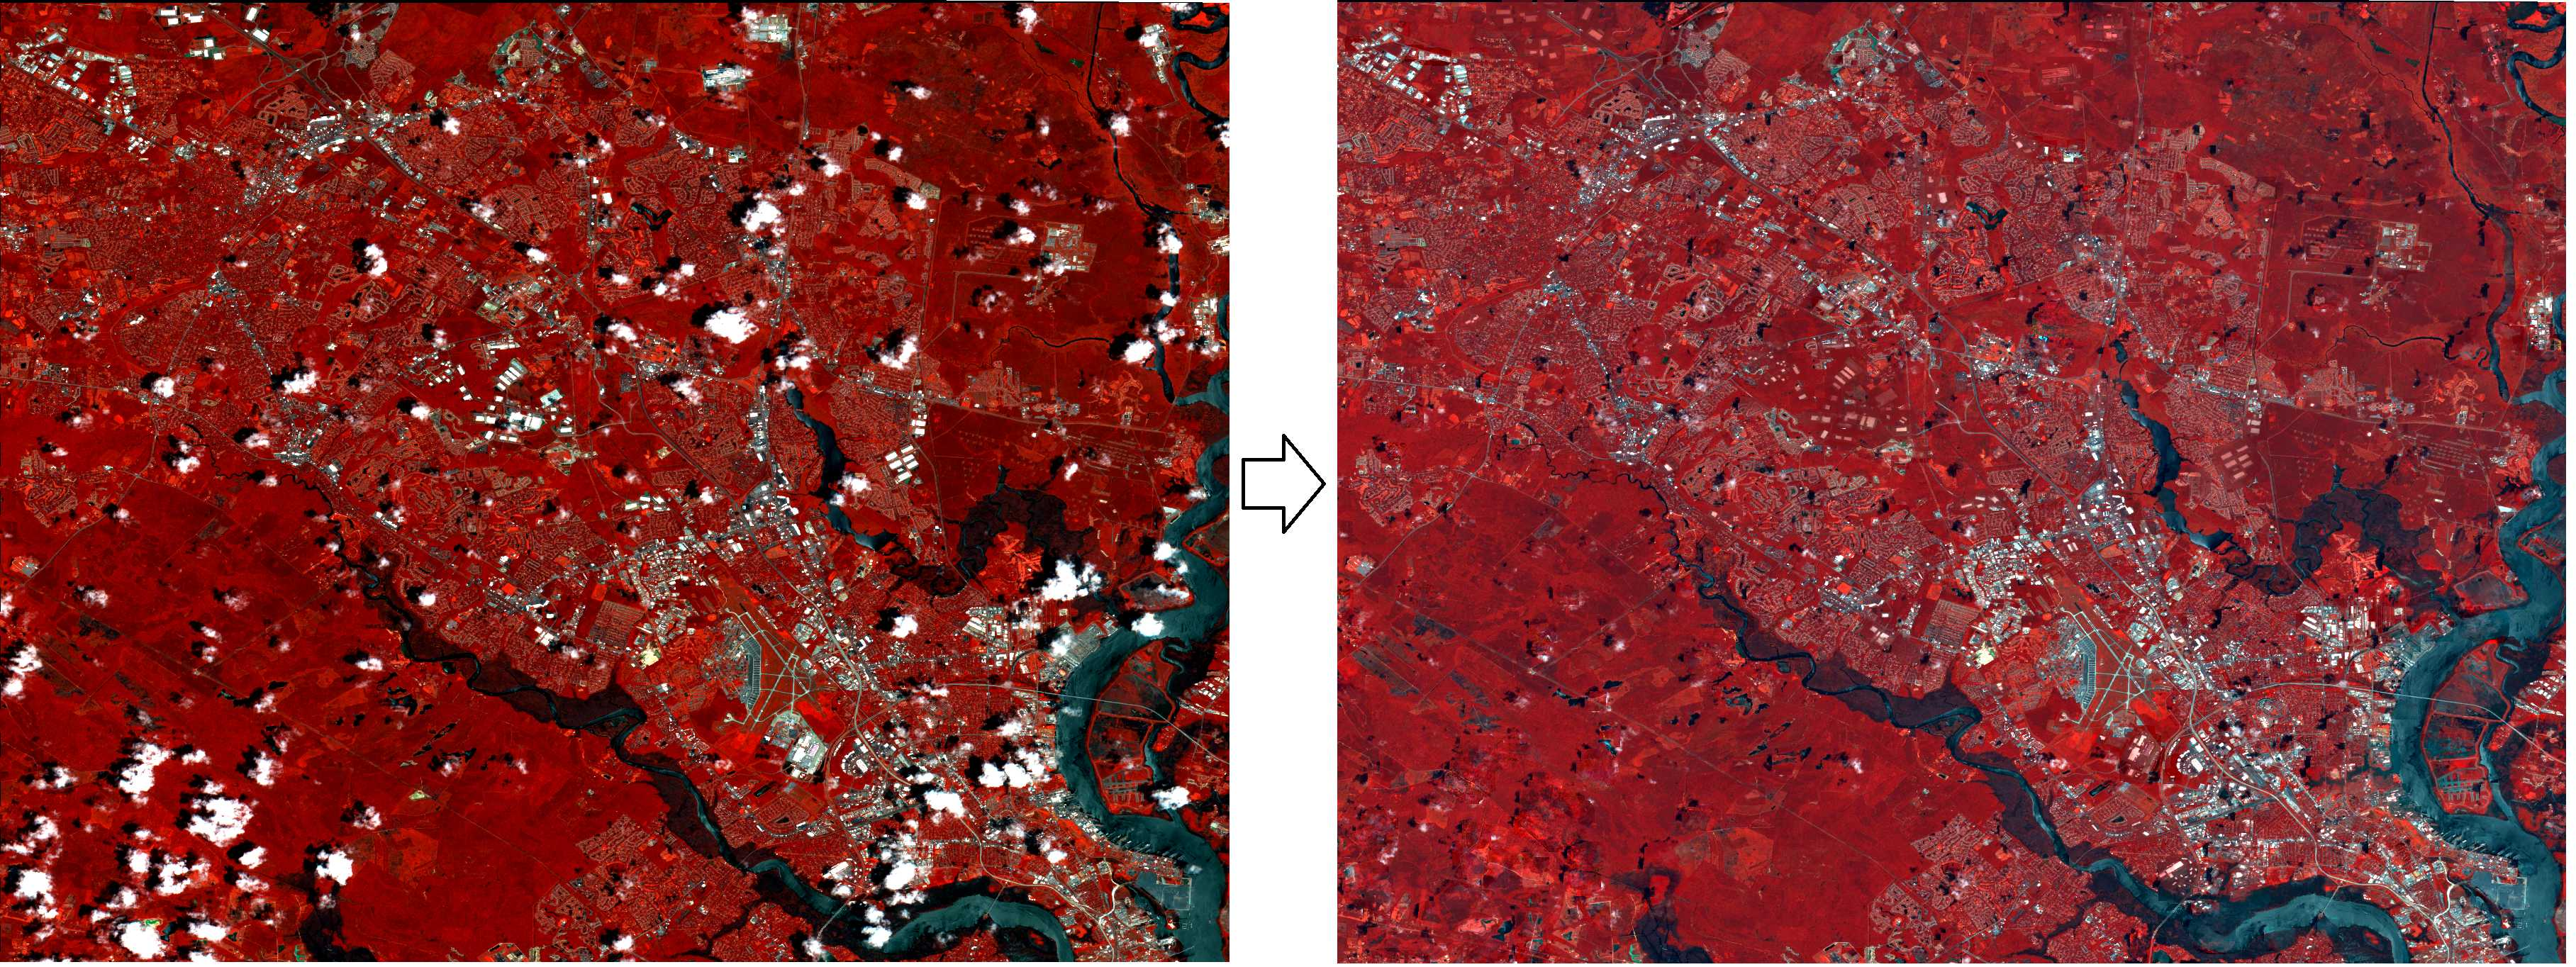 

## Conclusion

In this notebook, we have demonstrated a method to remove clouds from satellite imagery with a combination of a pretrained deep learning model and Esri raster functions. Further, it demonstrated how you can use your developed python raster functions in ArcGIS Pro.

## References

1. Li, Zhiwei, Huanfeng Shen, Qing Cheng, Wei Li, and Liangpei Zhang. "Thick cloud removal in high-resolution satellite images using stepwise radiometric adjustment and residual correction." Remote Sensing 11, no. 16 (2019): 1925.